# Using NLP to Predict Authenticity of Disasters

Final Project for DSCC440: Data Mining

**Jacob Brehm & Josh Jingtian Wang**

## Importing packages and set up

In [ ]:
import html
import re

import matplotlib.colors as mplc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import wordcloud
from PIL import Image
from textblob import TextBlob
pd.set_option('display.max_colwidth', None)

In [ ]:
!pwd

/content


In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## Data Preprocessing

First, we will combine the test and training data into a singular dataframe. We will then arbitrarily resplit the data set later on. This will intentionally give us a different split than the split provided by *Kaggle*.

In [ ]:
df = pd.concat([train_df, test_df])
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0


In [ ]:
print(f"There are {len(df)} rows in the concatenated dataframe.")
print(f"There are {len(train_df)} rows in the training dataframe.")
print(f"There are {len(test_df)} rows in the testing dataframe.")

There are 10876 rows in the concatenated dataframe.
There are 7613 rows in the training dataframe.
There are 3263 rows in the testing dataframe.


While the provided data set is already formatted quite nicely, it would be worthwhile to remove things like URLs, hashtags, and other select non-alphanumeric characters from the *text* column.

In [ ]:
def remove_urls(text: str, replacement: str="") -> str:
    """Removes URLs from a given string."""
    """Also removes @ mentions."""
    # Define the regex used to identify URLs
    url_expression = (
        r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)"
        r"(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s("
        r")<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    )
    # Replace any URLs with the replacement string
    text1 = re.sub(url_expression, replacement, text)
    
    #remove @ mentions and return
    return re.sub(r"@[A-Za-z0-9]+", replacement, text1)

In [ ]:
def remove_nonalphanumeric(text: np.str_) -> str:
    """
    Removes non-alphanumeric characters from a given string.
    
    Preserves spaces and quotation marks (to preserve contractions).
    """

    return re.sub("[^A-Za-z0-9 '\"]+", '', text)

In [ ]:
def remove_html_entities(text: str) -> str:
    """
    Removes HTML entities from a given string.
    
    These entities include, but are not limited to:
        &amp;
        &gt;
    """
    return html.unescape(text)

In [ ]:
df[df["text"].str.contains("firework")]["text"]

1062    this is about to be a bomb ass firework picture http://t.co/lr4BTvuEoM
Name: text, dtype: object

In [ ]:
df["text"] = df["text"].apply(remove_urls) # Must be done first
df["text"] = df["text"].apply(remove_html_entities) # Must be done second
df["text"] = df["text"].apply(remove_nonalphanumeric)

In [ ]:
#remove irrelevant string
df['text'] = df.text.str.replace('I liked a YouTube video', '').replace('I added a video to a YouTube playlist', '')

In [ ]:
df['text_lower'] = df.text.str.lower()
#removing duplicate tweets
df = df.drop_duplicates(subset=['text_lower'], keep='first')
df = df.reset_index(drop=True)

In [ ]:
df.head()

,id,keyword,location,text,target,text_lower
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all,1.0,our deeds are the reason of this earthquake may allah forgive us all
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1.0,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers No other evacuation or shelter in place orders are expected,1.0,all residents asked to 'shelter in place' are being notified by officers no other evacuation or shelter in place orders are expected
3,6,NaN,NaN,13000 people receive wildfires evacuation orders in California,1.0,13000 people receive wildfires evacuation orders in california
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school,1.0,just got sent this photo from ruby alaska as smoke from wildfires pours into a school


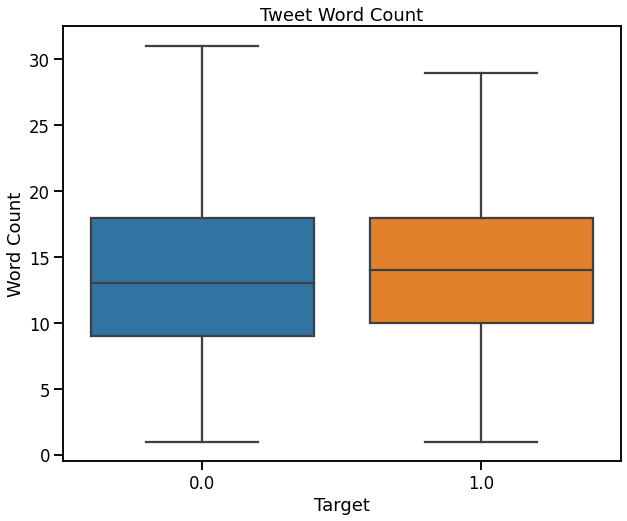

In [ ]:
df['word_count'] = [len(i) for i in df.text.str.split()]

plt.rcParams['figure.figsize'] = [10,8]
sns.set_context("talk")

sns.boxplot(x='target', y='word_count', data=df, fliersize=1).set(
    title='Tweet Word Count',
    xlabel='Target',
    ylabel='Word Count',
)

# plt.savefig("TextBlob Polarity.png",
#                   bbox_inches="tight",
#                   dpi = 400)

plt.show()

Now that these characters have been removed, it will be much easier to perform analysis on the dataframe as well as make visualizations--in particular, this will be useful for making wordclouds.

## Models and analysis

### Sentiment analysis

In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 5.2 MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
analyzer = SentimentIntensityAnalyzer()
analyzer.polarity_scores('What a wonderful day')['compound']

0.5719

In [ ]:
df["polarity"] = df["text"].apply(lambda text: TextBlob(text).polarity)
df["VADER_compound"] = df["text"].apply(lambda text: analyzer.polarity_scores(text)['compound'])
df.head()

,id,keyword,location,text,target,text_lower,polarity,VADER_compound
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all,1.0,our deeds are the reason of this earthquake may allah forgive us all,0.00000,0.2732
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1.0,forest fire near la ronge sask canada,0.10000,-0.3400
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers No other evacuation or shelter in place orders are expected,1.0,all residents asked to 'shelter in place' are being notified by officers no other evacuation or shelter in place orders are expected,-0.01875,-0.2960
3,6,NaN,NaN,13000 people receive wildfires evacuation orders in California,1.0,13000 people receive wildfires evacuation orders in california,0.00000,0.0000
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school,1.0,just got sent this photo from ruby alaska as smoke from wildfires pours into a school,0.00000,0.0000


In [ ]:
df.groupby(pd.cut(df["polarity"], [-1, -0.3, 0.3, 1]))["polarity"].count()

polarity
(-1.0, -0.3]     593
(-0.3, 0.3]     7853
(0.3, 1.0]      1251
Name: polarity, dtype: int64

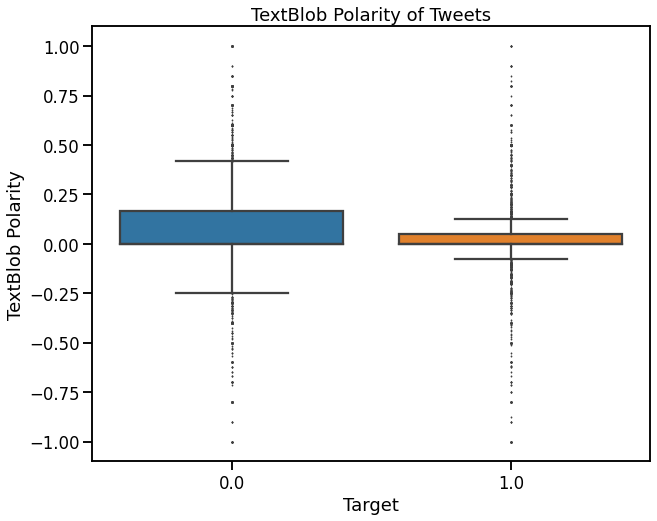

In [ ]:
sns.boxplot(x='target', y='polarity', data=df, fliersize=1).set(
    title='TextBlob Polarity of Tweets',
    xlabel='Target',
    ylabel='TextBlob Polarity',
)

# plt.savefig("TextBlob Polarity.png",
#                   bbox_inches="tight",
#                   dpi = 400)

plt.show()

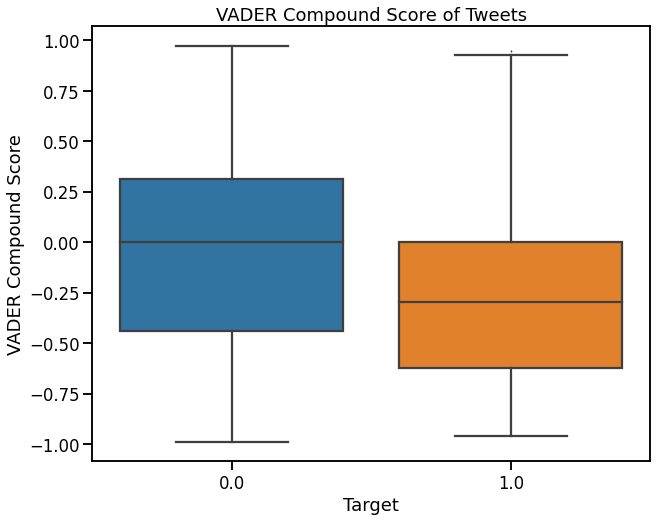

In [ ]:
sns.boxplot(x='target', y='VADER_compound', data=df, fliersize=1).set(
    title='VADER Compound Score of Tweets',
    xlabel='Target',
    ylabel='VADER Compound Score',
)

# ax.figure.savefig("VADER Compound Score.png",
#                   bbox_inches="tight",
#                   dpi = 400)

plt.show()

In [ ]:
import scipy.stats as stats

In [ ]:
stats.ttest_ind(a=df[df['target']==0.0]['polarity'], b=df[df['target']==1.0]['polarity'], equal_var=True)

Ttest_indResult(statistic=8.671691204878307, pvalue=5.242739567683484e-18)

In [ ]:
stats.ttest_ind(a=df[df['target']==0.0]['VADER_compound'], b=df[df['target']==1.0]['VADER_compound'], equal_var=True)

Ttest_indResult(statistic=19.3264350637691, pvalue=4.285704641844505e-81)

Sentiment of disaster tweets is significantly lower than that of non-disaster tweets

### Word Clouds

The first wordcloud will be in the shape of the Twitter logo, and it will include text from all tweets.

In [ ]:
text = "\n".join(i for i in df["text"])
stopwords = set(wordcloud.STOPWORDS)

twitter_mask = np.array(Image.open("twitter_mask.png"))

In [ ]:
def getwordcloud(target, colorlist):

  text = "\n".join(i for i in df[df['target']==target]["text_lower"])

  cloud = wordcloud.WordCloud(
    stopwords=stopwords,
    background_color="white",
    min_font_size = 2,
    max_font_size = 120,
    min_word_length = 3,           # sets the minimum word length
    repeat = False,                # will not repeat any words
    collocations = False,          # will not include pairs of words
    include_numbers = False,       # will not include numbers
    normalize_plurals = True,      # will remove trailing "s"s
    mask=twitter_mask,
    ).generate(text)

  # Create a custom colormap
  custom_colormap = mplc.LinearSegmentedColormap.from_list(
          'custom', colorlist
      )
  cloud.recolor(colormap=custom_colormap)

  # Show the wordcloud
  plt.figure(figsize=(20,20))
  plt.imshow(cloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

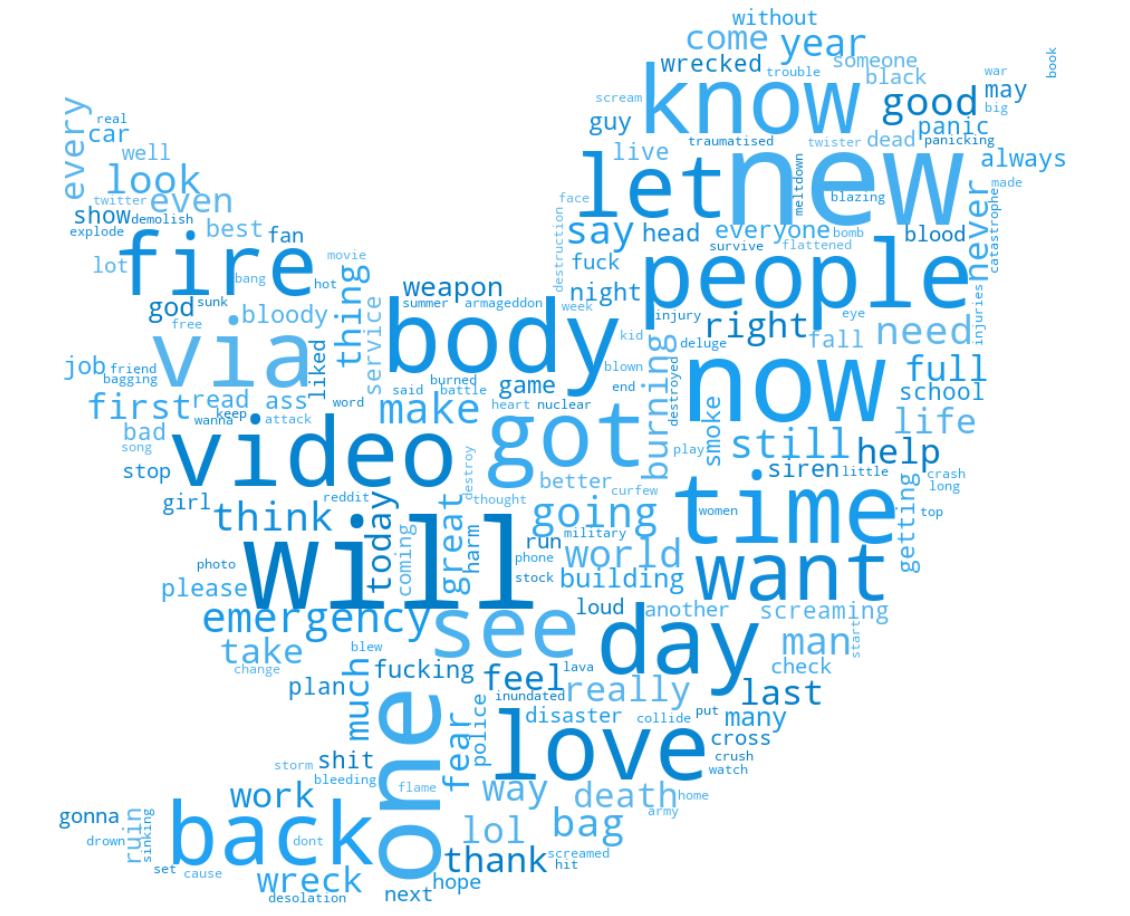

In [ ]:
#word cloud of non disaster tweets
colorlist = ["#61b8ed", "#1DA1F2", "#007ac4"]
getwordcloud(0, colorlist)

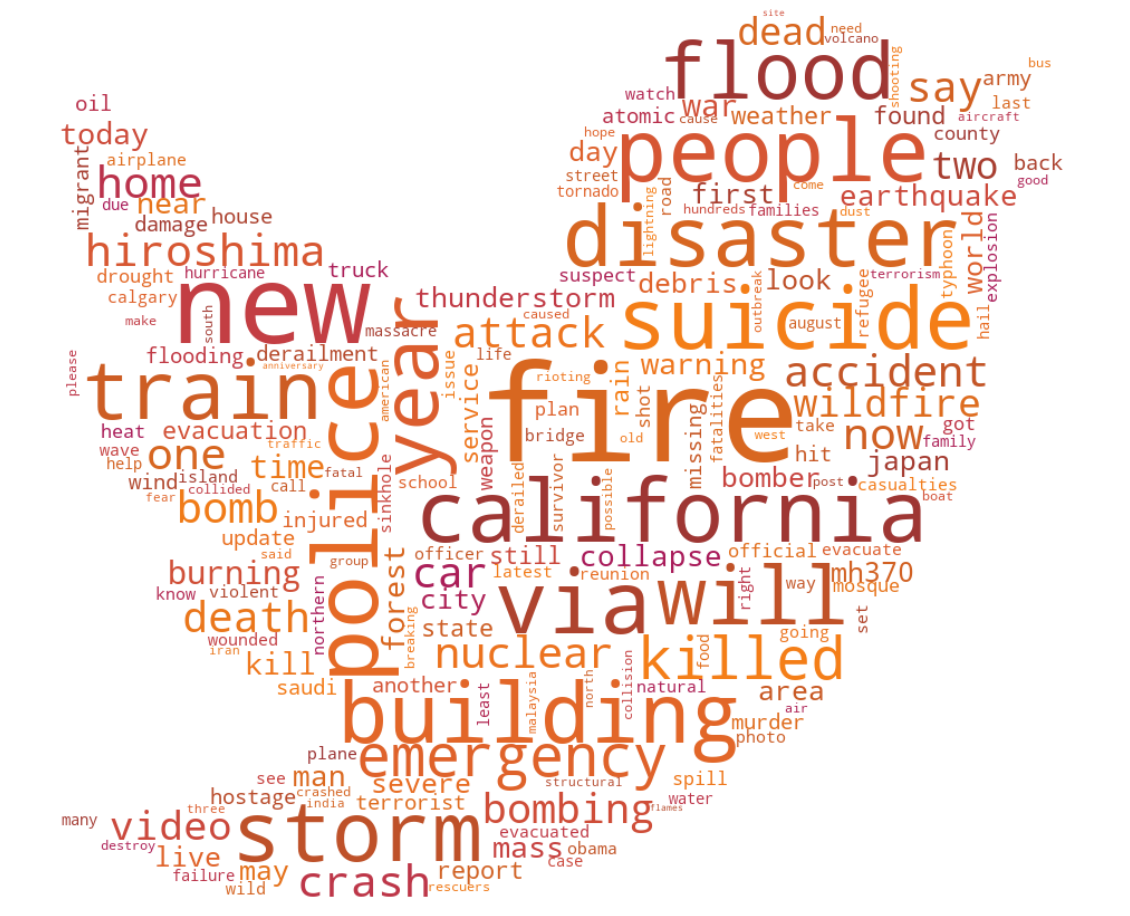

In [ ]:
#word cloud of disaster tweets
colorlist = ["#9C3434", "#F57F17", "#A91B5A"]
getwordcloud(1.0, colorlist)

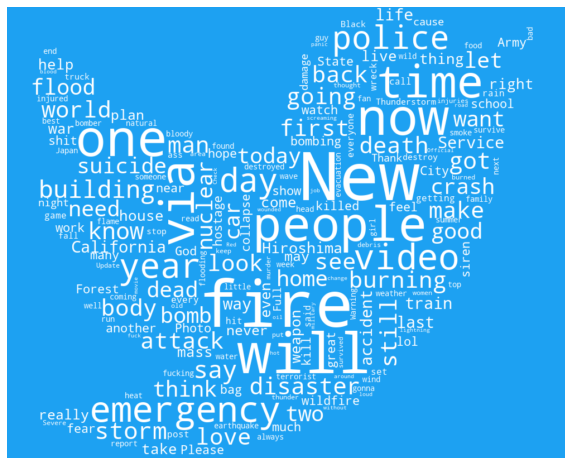

In [ ]:
# Generate the wordcloud
cloud = wordcloud.WordCloud(
    stopwords=stopwords,
    background_color="#1DA1F2",
    min_font_size = 2,
    max_font_size = 120,
    min_word_length = 3,           # sets the minimum word length
    repeat = False,                # will not repeat any words
    collocations = False,          # will not include pairs of words
    include_numbers = False,       # will not include numbers
    normalize_plurals = True,      # will remove trailing "s"s
    mask=twitter_mask,
    # contour_width = 2,
    # contour_color = "white",
    # margin=1,
).generate(text)

# Change the text color to just white
cloud.recolor(color_func=lambda *args, **kwargs: "white")

# Show the wordcloud
plt.figure(figsize=(10,10))
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()